In [ ]:
# install required libraries
!pip install -q cairosvg
!pip install -q chess

In [2]:
# import modules and libraries
import chess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib import Path
from cairosvg import svg2png
from sklearn.model_selection import train_test_split

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# define data dir
data_dir = Path('/content/drive/MyDrive/MAID/502 CI/project/data')

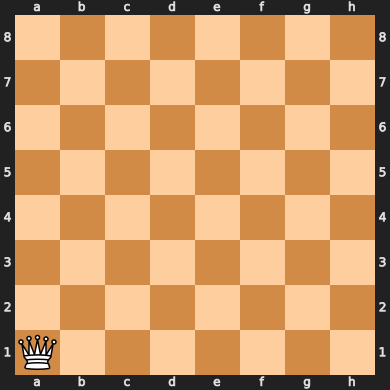

In [5]:
# visualize chessboard
b = chess.Board(None)
b.set_piece_at(chess.parse_square('a1'), chess.Piece.from_symbol('Q'))
b

In [6]:
# create dataset template
image_names = []
boards = []
labels = []

for idx, piece in enumerate(['k', 'K', 'q', 'Q']):
    for pos in chess.SQUARE_NAMES:
        b = chess.Board(None)
        b.set_piece_at(chess.parse_square(pos), chess.Piece.from_symbol(piece))
        
        # store image names, boards and labels
        img_name = 'image_' + str(idx) + str(pos) + '.png'
        image_names.append(img_name)
        boards.append(b)
        labels.append(idx)

In [11]:
# split data into training and validation
train_names, valid_names, train_boards, valid_boards, train_labels, valid_labels = train_test_split(image_names, boards, labels, train_size=0.8, shuffle=True, stratify=labels, random_state=42)

In [12]:
train_names[:5]

['image_1h3.png',
 'image_2h4.png',
 'image_1a5.png',
 'image_3g2.png',
 'image_1f4.png']

In [13]:
valid_names[:5]

['image_2h3.png',
 'image_0h8.png',
 'image_1f1.png',
 'image_0e4.png',
 'image_0c6.png']

In [14]:
len(train_names), len(valid_names)

(204, 52)

In [15]:
train_boards[:5]

[Board('8/8/8/8/8/7K/8/8 w - - 0 1'),
 Board('8/8/8/8/7q/8/8/8 w - - 0 1'),
 Board('8/8/8/K7/8/8/8/8 w - - 0 1'),
 Board('8/8/8/8/8/8/6Q1/8 w - - 0 1'),
 Board('8/8/8/8/5K2/8/8/8 w - - 0 1')]

In [16]:
train_labels[:5]

[1, 2, 1, 3, 1]

In [19]:
%%bash

mkdir -p "/content/drive/MyDrive/MAID/502 CI/project/data"/{train/{images/{blackKing,whiteKing,blackQueen,whiteQueen},annot_csv},valid/{images/{blackKing,whiteKing,blackQueen,whiteQueen},annot_csv}}


In [20]:
class_names = {
    0: 'blackKing',
    1: 'whiteKing',
    2: 'blackQueen',
    3: 'whiteQueen',
}

In [21]:
# save training images
for img_name, b, lbl in zip(train_names, train_boards, train_labels):
    img_path = str(data_dir / 'train' / 'images' / class_names[lbl] / img_name)
    svg2png(bytestring=chess.svg.board(b, size=224),write_to=img_path)

In [22]:
img_name, b, lbl, class_names[lbl], img_path

('image_2b4.png',
 Board('8/8/8/8/1q6/8/8/8 w - - 0 1'),
 2,
 'blackQueen',
 '/content/drive/MyDrive/MAID/502 CI/project/data/train/images/blackQueen/image_2b4.png')

In [23]:
# save validation images
for img_name, b, lbl in zip(valid_names, valid_boards, valid_labels):
    img_path = str(data_dir / 'valid' / 'images' / class_names[lbl] / img_name)
    svg2png(bytestring=chess.svg.board(b, size=224),write_to=img_path)

In [24]:
# define variables for automated labelling
border_width = 8
width = 224

low = border_width
high = width - border_width
gap = (high - low) // 8
low, high, gap

(8, 216, 26)

In [25]:
# define x coordinate at the center of chess position a1
x_center0 = low + gap / 2
x_center0

21.0

In [26]:
# define y coordinate at the center of chess position a1
y_center0 = high - gap / 2
y_center0

203.0

In [27]:
# find all possible center coordinates
xvals = np.arange(x_center0, y_center0+1, gap, dtype=int)
yvals = np.arange(y_center0, x_center0-1, -gap, dtype=int)
xvals, yvals

(array([ 21,  47,  73,  99, 125, 151, 177, 203]),
 array([203, 177, 151, 125,  99,  73,  47,  21]))

In [28]:
# create center coordinates for every chess position
coordinates = []
for xcenter in xvals:
    for ycenter in yvals:
        coordinates.append([xcenter, ycenter])
        
coordinates[:5]

[[21, 203], [21, 177], [21, 151], [21, 125], [21, 99]]

In [29]:
len(coordinates)

64

In [30]:
# create name for every chess position
pos = []
for filename in chess.FILE_NAMES:
    for rankname in chess.RANK_NAMES:
        pos.append(filename + rankname)
        
pos[:5]

['a1', 'a2', 'a3', 'a4', 'a5']

In [31]:
# merge the above two lists into a dictionary
pos_dict = dict(zip(pos, coordinates))

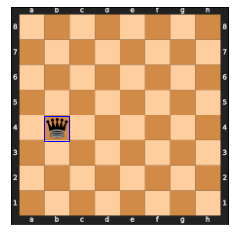

Label is blackQueen


In [35]:
## visualize random images and their corresponding annotations

# get random index
idx = np.random.randint(len(train_names))

# get filename and stem of random index
_stem = Path(train_names[idx]).stem
img_name = Path(train_names[idx]).name

# get position and label
pos = _stem.split('_')[1][1:]
label = int(_stem.split('_')[1][0])

# get image path
img_path = str(data_dir / 'train' / 'images' / class_names[label] / img_name)

# read image
img = plt.imread(img_path)

# find center coordinates
xcenter, ycenter = pos_dict[pos]

# plot image with annotations
plt.imshow(img, origin='upper')
rect = patches.Rectangle((xcenter - gap/2, ycenter - gap/2), gap, gap, linewidth=1, edgecolor='b', facecolor='none')
plt.gca().add_patch(rect)

plt.xticks([])
plt.yticks([])

plt.show()
print('Label is', class_names[label])

In [36]:
# create train csv file
train_data = []
for img_name in train_names:
    # get filename and stem of random index
    _stem = Path(img_name).stem

    # get position, label and class name
    pos = _stem.split('_')[1][1:]
    label = int(_stem.split('_')[1][0])
    class_name = class_names[label]

    # find center coordinates
    xcenter, ycenter = pos_dict[pos]

    # store details
    train_data.append([img_name, class_name, xcenter, ycenter, gap, gap])

In [37]:
# store all annotations in a simple format
train_data = pd.DataFrame(train_data, columns=['filename', 'label', 'xcenter', 'ycenter', 'width', 'height'])
train_data.head()

,filename,label,xcenter,ycenter,width,height
0,image_1h3.png,whiteKing,203,151,26,26
1,image_2h4.png,blackQueen,203,125,26,26
2,image_1a5.png,whiteKing,21,99,26,26
3,image_3g2.png,whiteQueen,177,177,26,26
4,image_1f4.png,whiteKing,151,125,26,26


In [39]:
# save as csv file
train_data.to_csv(data_dir / 'train' / 'annot_csv' / 'train.csv', index=False)

In [40]:
# create validation csv file
valid_data = []
for img_name in valid_names:
    # get filename and stem of random index
    _stem = Path(img_name).stem

    # get position, label and class name
    pos = _stem.split('_')[1][1:]
    label = int(_stem.split('_')[1][0])
    class_name = class_names[label]

    # find center coordinates
    xcenter, ycenter = pos_dict[pos]

    # store details
    valid_data.append([img_name, class_name, xcenter, ycenter, gap, gap])

# store all annotations in a simple format
valid_data = pd.DataFrame(valid_data, columns=['filename', 'label', 'xcenter', 'ycenter', 'width', 'height'])

# save as csv file
valid_data.to_csv(data_dir / 'valid' / 'annot_csv' / 'valid.csv', index=False)